# Gaussian Mixture Models

In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind *K*-means, but can also be a powerful tool for **density estimation** beyond simple clustering.

## Basics

Gaussian mxiture models

* assume that the data, with a **prior probability** $\pi_c$ ($\sum_{c=1}^K \pi_c= 1$), are independently sampled from one of the $K$ Gaussian distributions $\mathcal{N}(\mu_c, \Sigma_c)$, $c = 1,\dots, K$. 

* we want to infer the model parameters $\mu_c$'s, $\Sigma_c$'s, and $\pi_c$'s from a set of observed data.

* the learning problem is solved by **expectation-maximization (E-M) algorithm**.

* with known/infered parameters, for any data $x\in\mathbb{R}^d$, the **posterior probability** that $x$ is sampled from the $c$-th Gassusian distribution is *proportional to* $\pi_c p(x|\mu_c, \Sigma_c)$, 
where
$$
p(x|\mu_c, \Sigma_c)
=  \frac{1}{\sqrt{(2\pi)^d |\Sigma_c|}} \exp\left( -\frac{1}{2} (x - \mu_c)^\top \Sigma_c^{-1} (x - \mu_c)\right)
$$ is the pdf of Gaussian distribution $\mathcal{N}(\mu_c, \Sigma_c)$.


* Applications:
    - **clustering**: assign $x$ to the Gassian distribution (i.e., cluster) with the highest posterior probability $\propto \pi_c p(x|\mu_c, \Sigma_c)$.
    - **density estimation**: the estimated pdf for the Gaussian mxiture is
    $$
    \sum_{c=1}^K \pi_c \, p(x|\mu_c, \Sigma_c),
    $$
    
    so it can be used as a generative model for generating new data points.

<img src = '../figs/12_mixture.png' width = '600'>

We begin with the standard imports:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM: Weaknesses of K-Means

Given simple, well-separated data, *K*-means finds suitable clustering results. For example, if we have simple blobs of data, the *K*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [1]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

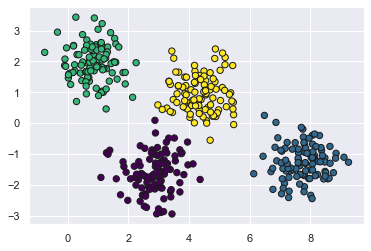

In [4]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', edgecolor = 'k');

We can visualize this cluster model with the following function:

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, edgecolor='k')

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

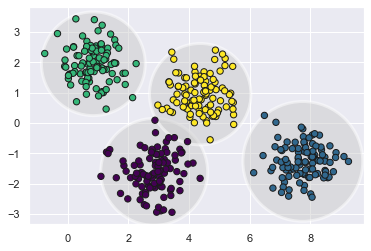

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for *K*-means is that these cluster models **must be circular**: *K*-means has no built-in way of accounting for elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming failure:

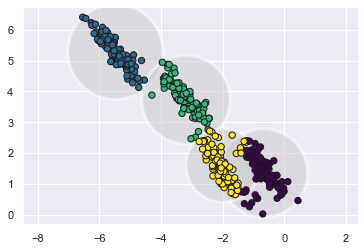

In [7]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit. Nevertheless, *K*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters. This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.

In summary, *K*-means has two disadvantages:

* lack of flexibility in cluster shape 

* lack of probabilistic cluster assignment

## Generalizing E-M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

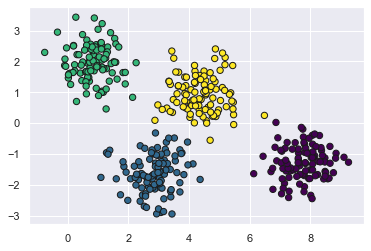

In [8]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', edgecolor = 'k');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.469 0.    0.    0.531]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

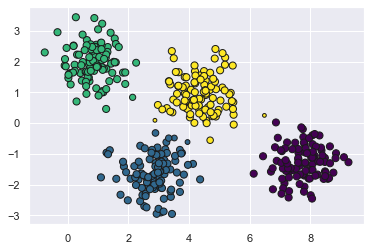

In [10]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size, edgecolor = 'k');

Under the hood, a Gaussian mixture model is very similar to *K*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, update its cluster assignment in a probabilistic manner using current parameters.
   
   2. *M-step*: for each cluster, update the membership probability, and the estimated mean and covariance for the associated Gaussian distribution

Each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *K*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

We create a function that visualize the GMM clusters by drawing ellipses based on the GMM output:

In [11]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, edgecolor = 'k')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, edgecolor = 'k')
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

<img src = '../figs/12_covariance.png' width = '400'>

- Square roots of eigenvalues of covariance matrix specify the axis ratio

- Eigenvectors specify the rotation of axes

We take a look at what the four-component GMM gives for our initial data:

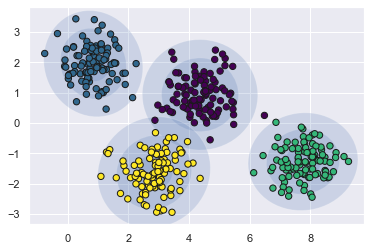

In [12]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

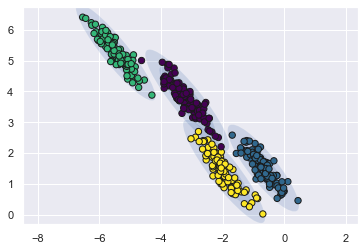

In [13]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

### Choosing the covariance type

The ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"`` (diagonal covariance matrix), which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"`` (multiple of identity covariance matrix), which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"`` (general positive semi-definite covariance matrix), which allows each cluster to be modeled as an ellipse with arbitrary orientation.

<img src = '../figs/12_covariance-type.png' width = '1200'>

## Gaussian Mixture Models as Density Estimation

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function.

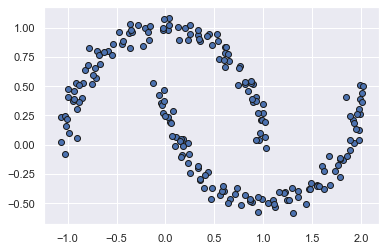

In [14]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], edgecolor = 'k');

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

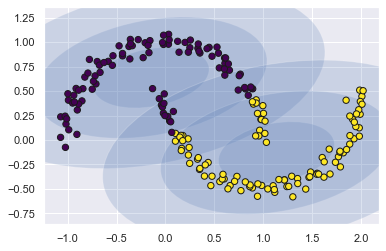

In [15]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

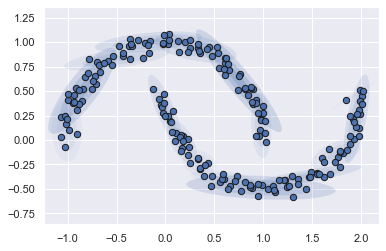

In [16]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall **distribution** of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

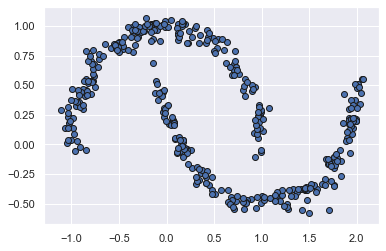

In [17]:
Xnew = gmm16.sample(n_samples= 400)[0] # sample method returns a tuple containing the np.array of data

plt.scatter(Xnew[:, 0], Xnew[:, 1], edgecolor = 'k');

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The choice of number of components measures how well GMM works **as a density estimator**. We can use some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) to choose the optimal number of components or Gaussian distributions.
Scikit-Learn's ``GaussianMixture`` includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for the moon dataset:

In [ ]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of components is the value that **minimizes the AIC or BIC**. The AIC implies that around 8-12 components would have been a better choice than 16, whereas the BIC recommends a simpler model.

### Generate New Image Data

We will use GMM to generate **new handwritten digits** from the standard digits corpus that we have used before.

Let's load the digits data using Scikit-Learn's data tools:

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

Next let's plot the first 100 images:

In [ ]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more.
GMMs can have difficulty converging in such a high dimensional space, so we will start with PCA for dimensionality reduction, asking it to preserve 99% of the variance in the projected data:

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99) # to preserve 99% of the variance
data = pca.fit_transform(digits.data)
data.shape

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss.
Given this projected data, let's use the AIC to get a gauge for the number of GMM components we should use:

In [ ]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It appears that around 160 components minimizes the AIC; we will use this model.
Let's quickly fit this to the data and confirm that it has converged:

In [ ]:
gmm = GaussianMixture(160, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

In [ ]:
data_new = gmm.sample(100)[0]
data_new.shape

Finally, we can use the inverse transform of the PCA object to construct the new digits:

In [ ]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

The results for the most part look like plausible digits from the dataset.

Given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, yet capture the general features of the input data as modeled by the mixture model.